# Project Week 1: ActivityNet Video Data Preparation and Indexing

In this example we will use the ActivityNet dataset https://github.com/activitynet/ActivityNet. 

 - Select the 10 videos with more moments.
 - Download these videos onto your computer.
 - Extract the frames for every video.
 - Read the textual descriptions of each video.
 - Index the video data in OpenSearch.

 In this week, you will index the video data and make it searchable with OpenSearch. You should refer to the OpenSearch tutorial laboratory.

## Select videos
Download the `activity_net.v1-3.min.json` file containing the list of videos. The file is in the github repository of ActivityNet.
Parse this file and select the 10 videos with more moments.

In [1]:
import json
import os

from numpy.random import shuffle
from yt_dlp import YoutubeDL
import requests
import pickle as pk
import av
import pprint as pp
from opensearchpy import OpenSearch
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import numpy as np

FRAMES_DIR = "frames"
path = "downloads/"

host = 'localhost'
port = 9200

nova_host = 'api.novasearch.org'
nova_port = 443

user = 'user10' # Add your user name here.
password = '2025.grupo10' # Add your user password here. For testing only. Don't store credentials in code. 

local_user = 'admin'
local_pwd = '2025.Grupo10' # Add your local password here. For testing only. Don't store credentials in code.
index_name = user

DOWNLOAD_DIR = "downloads"
FRAMES_DIR = "frames"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

In [4]:
def download_video(video_id, url):
    output_path = os.path.join(DOWNLOAD_DIR, f"{video_id}.mp4")
    if os.path.exists(output_path):
        print(f"Already downloaded: {video_id}")
        return

    ydl_opts = {
        'outtmpl': output_path,
        'format': 'best[ext=mp4]/best',
        'quiet': False,
        'noplaylist': True,
        'retries': 3
    }

    try:
        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
    except Exception as e:
        print(f"Failed to download {video_id}: {str(e)}")


def is_youtube_video_available(id):
    try:
        oembed_url = f"https://www.youtube.com/oembed?url=http://www.youtube.com/watch?v={id}&format=json"
        response = requests.get(oembed_url)     
        if response.status_code != 200:
             return False
        
        url = f"https://www.youtube.com/watch?v={id}"
        
        response = requests.get(url)
        content = response.text

        # Check if the video is available by verifying the attribute "playabilityStatus"
        if 'playabilityStatus' in content:
            if '"status":"UNPLAYABLE"' in content:
                return False
            if '"status":"AGE_VERIFICATION_REQUIRED"' in content:
                return False
            if '"status":"LOGIN_REQUIRED"' in content:
                return False
            
       
        return True

    except Exception as e:
        print(f"Error checking video {id}: {str(e)}")
        return False

with open('activity_net.v1-3.min.json', 'r') as json_data:
    moments_data = json.load(json_data)
    moments_data = moments_data['database']

with open('captions/train.json', 'r') as json_data:
    captions_data = json.load(json_data)

video_stats = []
for id, video_data in moments_data.items():
        num_moments = len(video_data.get('annotations', []))
        if "v_" + id not in captions_data:
             continue
        num_captions = len(captions_data["v_" + id]['sentences'])
        total = num_moments + num_captions
        video_stats.append({
            'id': id,
            'length': video_data.get('duration', ''),
            'resolution': video_data.get('resolution', ''),
            'num_moments': num_moments,
            'num_captions': num_captions,
            'url': video_data.get('url', ''),
            'total': total
        })

video_stats.sort(key=lambda x: x['total'], reverse=True)
top_videos = video_stats[:75]

top_10_videos = []
for video in top_videos:
    if is_youtube_video_available(video['id']) and len(top_10_videos) < 75:
        top_10_videos.append(video)



for video in top_10_videos:
     #print(f"Video url: {video['url']}")
     download_video(video['id'], video['url'])
     
     
with open('phase1/top_10_videos.pkl', 'wb') as f:
    pk.dump(top_10_videos, f)
    
with open('phase1/moments_data.pkl', 'wb') as f:
    pk.dump(moments_data, f)
    
with open('phase1/captions_data.pkl', 'wb') as f:
    pk.dump(captions_data, f)

Already downloaded: tuhHQ-lHIs4
Already downloaded: o1WPnnvs00I
Already downloaded: oGwn4NUeoy8
Already downloaded: -fjUWhSM6Hc
Already downloaded: qF3EbR8y8go
Already downloaded: DLJqhYP-C0k
Already downloaded: jBvGvVw3R-Q
Already downloaded: -rKS00dzFxQ
Already downloaded: VEDRmPt_-Ms
Already downloaded: v7o9uSu9AVI
Already downloaded: RJpWgi0EaUE
Already downloaded: lxMSX0Y0b8I
Already downloaded: cGNkR-JvaJs
Already downloaded: nOvrsb0XyGk
Already downloaded: FXb8rBMvol4
Already downloaded: jTMdMnbW9OI
Already downloaded: Eilil6FZhK8
Already downloaded: G7kqlq8WhRo
Already downloaded: OVRYoPA6h-Y
Already downloaded: ybcStSlBGPc
Already downloaded: sWaU9O4xzFE
Already downloaded: 9wtMJoqGTg0
Already downloaded: DMw9Cb_Xy2A
Already downloaded: Ffi7vDa3C2I
Already downloaded: -ap649M020k
Already downloaded: ekgfptN7tQk
Already downloaded: ynpvos7UFZo
Already downloaded: JRr3BruqS2Y
Already downloaded: 8JKK6JayDeA
Already downloaded: kdRcWkrZRZo
Already downloaded: 539ByIcbUPs
Already 

## Video frame extraction

PyAV is a wrapper library providing you access to `ffmpeg`, a command-line video processing tool. In the example below, you will be able to extract frames from the a video shot.

In [5]:
import os
import av

# Create the frames directory if it doesn't exist
os.makedirs(FRAMES_DIR, exist_ok=True)

videos = os.listdir(path)

for video in videos:
    video_name, _ = os.path.splitext(video)
    video_frames_dir = os.path.join(FRAMES_DIR, video_name)
    
    #only process the frames of the video if the directory does not exist
    if os.path.exists(video_frames_dir):
        print(f"Frames already extracted for {video_name}. Skipping...")
        continue
        
    os.makedirs(video_frames_dir, exist_ok=True)

    print(f"Processing video: {video_name}")
    video_path = os.path.join(path, video)

    with av.open(video_path) as container:
        stream = container.streams.video[0]
        time_base = stream.time_base

        saved_seconds = set()

        for frame in container.decode(stream):
            if frame.pts is None:
                continue  # Skip frames without PTS

            timestamp_seconds = int(frame.pts * time_base)

            # Save only one frame per 3 seconds
            if timestamp_seconds % 5 == 0 and timestamp_seconds not in saved_seconds:
                saved_seconds.add(timestamp_seconds)
                frame_path = os.path.join(video_frames_dir, f"{video_name}_{timestamp_seconds:04d}.jpg")
                frame.to_image().save(frame_path, quality=80)


Frames already extracted for -ap649M020k. Skipping...
Frames already extracted for -fjUWhSM6Hc. Skipping...
Frames already extracted for -rKS00dzFxQ. Skipping...
Processing video: 0-F3q8Aj9Zk
Frames already extracted for 0z7qHOca3D4. Skipping...
Processing video: 4XGQR2VmWpw
Frames already extracted for 539ByIcbUPs. Skipping...
Processing video: 5QZpCDyXNx4
Frames already extracted for 74MEdLMrXAQ. Skipping...
Frames already extracted for 8JKK6JayDeA. Skipping...
Processing video: 8OA30kYcAUQ
Processing video: 9DVsv84awMg
Processing video: 9WmsYbZl1pw
Frames already extracted for 9wtMJoqGTg0. Skipping...
Frames already extracted for b0LY869JBrE. Skipping...
Processing video: b40ECuGuck8
Processing video: b5SYTLjp6HI
Processing video: bBXbFpJMveI
Frames already extracted for BO0vQ6ASVlo. Skipping...
Frames already extracted for cGNkR-JvaJs. Skipping...
Frames already extracted for DLJqhYP-C0k. Skipping...
Frames already extracted for DMw9Cb_Xy2A. Skipping...
Frames already extracted for

## OpenSearch configuration

In [2]:
# Create the client with SSL/TLS enabled, but hostname verification disabled.
"""client = OpenSearch(
    hosts = [{'host': host, 'port': port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (local_user, local_pwd),
    use_ssl = True,
    #url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)"""


client = OpenSearch(
    hosts = [{'host': nova_host, 'port': nova_port}],
    http_compress = True, # enables gzip compression for request bodies
    http_auth = (user, password),
    use_ssl = True,
    url_prefix = 'opensearch_v2',
    verify_certs = False,
    ssl_assert_hostname = False,
    ssl_show_warn = False
)


if client.indices.exists(index_name):

    resp = client.indices.open(index = index_name)
    print(resp)

    print('\n----------------------------------------------------------------------------------- INDEX SETTINGS')
    settings = client.indices.get_settings(index = index_name)
    pp.pprint(settings)

    print('\n----------------------------------------------------------------------------------- INDEX MAPPINGS')
    mappings = client.indices.get_mapping(index = index_name)
    pp.pprint(mappings)

    print('\n----------------------------------------------------------------------------------- INDEX #DOCs')
    print(client.count(index = index_name))
else:
    print("Index does not exist.")


{'acknowledged': True, 'shards_acknowledged': True}

----------------------------------------------------------------------------------- INDEX SETTINGS
{'user10': {'settings': {'index': {'creation_date': '1744735330417',
                                   'knn': 'true',
                                   'number_of_replicas': '0',
                                   'number_of_shards': '4',
                                   'provided_name': 'user10',
                                   'refresh_interval': '-1',
                                   'replication': {'type': 'DOCUMENT'},
                                   'uuid': 'ersV7K2lSt6uaJE0kQ6NsQ',
                                   'version': {'created': '136387927'}}}}}

----------------------------------------------------------------------------------- INDEX MAPPINGS
{'user10': {'mappings': {'dynamic': 'strict',
                         'properties': {'caption_id': {'type': 'keyword'},
                                        'captio

### Index Deletion

In [64]:
#This line is here to prevent you from inadvertently deleting data.

if client.indices.exists(index=index_name):
    # Delete the index.
    response = client.indices.delete(
        index = index_name
    )
    print('\nDeleting index:')
    print(response)


Deleting index:
{'acknowledged': True}


### Index Creation

In [65]:
index_body = {
    "settings": {
        "index": {
            "number_of_replicas": 0,
            "number_of_shards": 4,
            "refresh_interval": "-1",
            "knn": "true"
        }
    },
    "mappings": {
        "dynamic": "strict",
        "properties": {
            "video_id": {"type": "keyword"},
            "video_url": {"type": "keyword"},            
            "video_length": {"type": "keyword"},
            "video_resolution": {"type": "keyword"},
            "video_frames_path": {"type": "keyword"},
            "video_moments": {"type": "text"},
            "caption_text": {"type": "text"},
            "caption_timestamp": {"type": "text"},
            "sentence_embedding": {
                "type": "knn_vector",
                "dimension": 768,
                "method": {
                    "name": "hnsw",
                    "space_type": "cosinesimil",
                    "engine": "lucene",
                    "parameters": {
                        "ef_construction": 256,
                        "m": 48
                    }
                }
            }
        }
    }
}

if client.indices.exists(index=index_name):
    print("Index already existed. You may force the new mappings.")
else:        
    response = client.indices.create(index_name, body=index_body)
    print('\nCreating index:')
    print(response)


Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'user10'}


### Sentence Embedding

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")

### Process the videos and captions

In [1]:
video_data = []
top_10_videos = pk.load(open('phase1/top_10_videos.pkl', 'rb'))
moments_data = pk.load(open('phase1/moments_data.pkl', 'rb'))
captions_data = pk.load(open('phase1/captions_data.pkl', 'rb'))

video_caption_docs = []

for video in top_10_videos:
    video_id = video['id']
    video_url = video['url']
    video_length = video['length']
    video_resolution = video['resolution']
    video_moments = moments_data[video_id]['annotations']
    video_timestamps = captions_data["v_" + video_id]['timestamps']
    video_captions = captions_data["v_" + video_id]['sentences']
    video_frames_path = FRAMES_DIR + "/" + video_id
    emb = encode(video_captions)
    
    #emb_avg = np.mean([e.numpy() for e in emb], axis=0) #TODO: testar com isto

    for i, caption in enumerate(video_captions):
        ts = video_timestamps[i]
        doc = {
            "video_id": video_id,
            "video_url": video_url,
            "video_length": video_length,
            "video_resolution": video_resolution,
            "video_frames_path": video_frames_path,
            "video_moments": json.dumps(video_moments),
            "caption_text": caption,
            "caption_timestamp": ts,
            "sentence_embedding": emb[i].numpy()
        }
        video_caption_docs.append(doc)
    
with open('phase1/video_captions_docs.pkl', 'wb') as f:
   pk.dump(video_caption_docs, f)

NameError: name 'pk' is not defined

### Index the video data

In [67]:
video_caption_docs = pk.load(open('phase1/video_captions_docs.pkl', 'rb'))
for doc in video_caption_docs:
    resp = client.index(index=index_name, body=doc)
    print(resp['result'])
    
client.indices.refresh(index=index_name)
count = client.count(index=index_name)
print("Document count:", count['count'])


created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created
created


# 2.4

## Queries



------------------------------------------------------------
🔍 Search Results for Query: 'animal'
------------------------------------------------------------

Result 1:
Video ID: kdRcWkrZRZo
Score: 0.6484
Video URL: https://www.youtube.com/watch?v=kdRcWkrZRZo
Video Frames Path: frames/kdRcWkrZRZo
Caption Text:  A man is shown walking near a boat with dogs.
Caption Timestamp: [34.02, 44.76]
🖼️ Frames for the caption:
Displaying: frames/kdRcWkrZRZo/kdRcWkrZRZo_0035.jpg


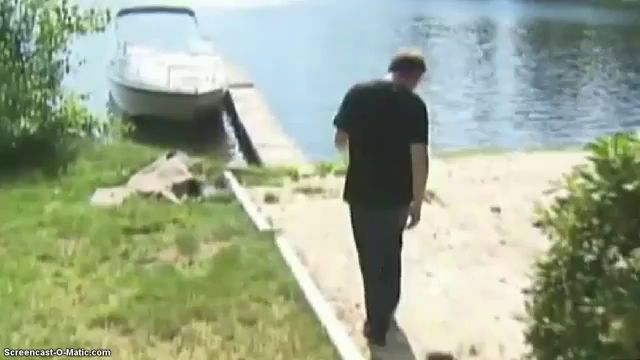

Displaying: frames/kdRcWkrZRZo/kdRcWkrZRZo_0040.jpg


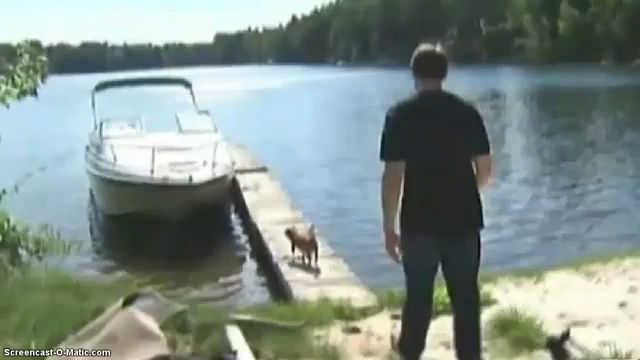


Result 2:
Video ID: 4XGQR2VmWpw
Score: 0.6452
Video URL: https://www.youtube.com/watch?v=4XGQR2VmWpw
Video Frames Path: frames/4XGQR2VmWpw
Caption Text:  We see a lake, and a dog followed by a bike on a street.
Caption Timestamp: [95.42, 103.92]
🖼️ Frames for the caption:
Displaying: frames/4XGQR2VmWpw/4XGQR2VmWpw_0095.jpg


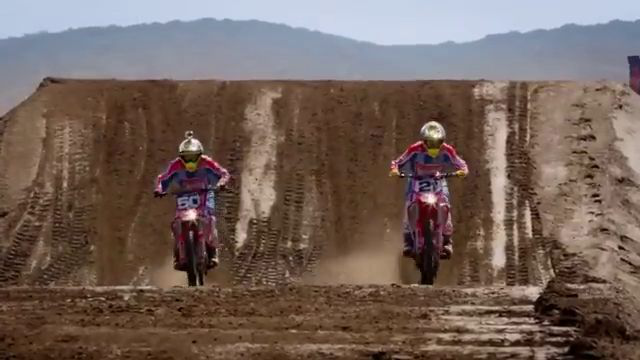

Displaying: frames/4XGQR2VmWpw/4XGQR2VmWpw_0100.jpg


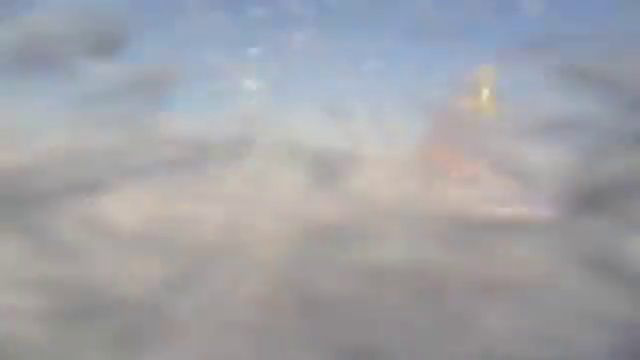


Result 3:
Video ID: BO0vQ6ASVlo
Score: 0.6316
Video URL: https://www.youtube.com/watch?v=BO0vQ6ASVlo
Video Frames Path: frames/BO0vQ6ASVlo
Caption Text: A man holds a frisbee next to a dog, then the dog jumps above the back of the man and grabs a frisbee.
Caption Timestamp: [0, 11.3]
🖼️ Frames for the caption:
Displaying: frames/BO0vQ6ASVlo/BO0vQ6ASVlo_0000.jpg


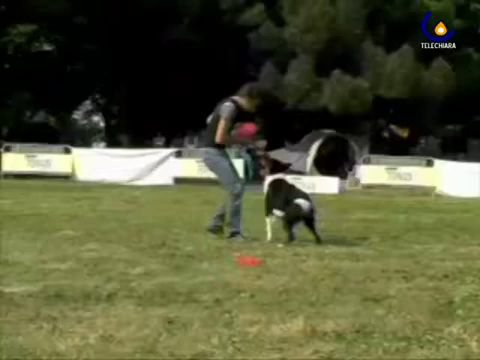

Displaying: frames/BO0vQ6ASVlo/BO0vQ6ASVlo_0005.jpg


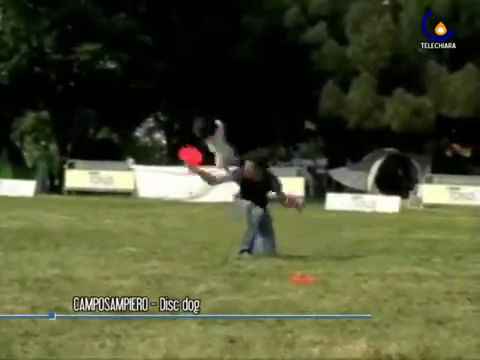

Displaying: frames/BO0vQ6ASVlo/BO0vQ6ASVlo_0010.jpg


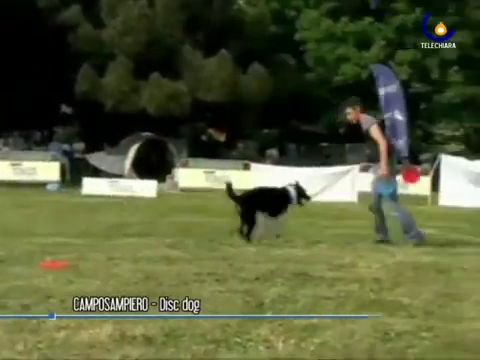

------------------------------------------------------------


In [4]:
# Compute the query embedding
query = "animal"
query_emb = encode(query)

query_denc = {
  'size':3,
  '_source': ['video_id', 'video_url', 'video_frames_path', 'caption_text', 'caption_timestamp'],
   "query": {
        "knn": {
          "sentence_embedding": {
            "vector": query_emb[0].numpy(),
            "k": 3
          }
        }
      }
}

query_denc_1 = {
    'size':3,
    '_source': ['video_id', 'video_url', 'video_frames_path', 'caption_text', 'caption_timestamp'],
     'query': {
        "term": {
            "caption_text" : query,
        }
   }
}

response = client.search(
    body = query_denc,
    index = index_name
)

from PIL import Image
from IPython.display import display  # Only works in Jupyter environments

def pretty_print_results(response, query):
    print(f"\n\n{'-' * 60}")
    print(f"🔍 Search Results for Query: '{query}'")
    print(f"{'-' * 60}")

    hits_sorted = sorted(response['hits']['hits'], key=lambda x: x['_score'], reverse=True)

    for i, hit in enumerate(hits_sorted):
        print(f"\nResult {i + 1}:")
        print(f"Video ID: {hit['_source']['video_id']}")
        print(f"Score: {hit['_score']:.4f}")
        print(f"Video URL: {hit['_source']['video_url']}")
        print(f"Video Frames Path: {hit['_source']['video_frames_path']}")
        print(f"Caption Text: {hit['_source']['caption_text']}")
        print(f"Caption Timestamp: {hit['_source']['caption_timestamp']}")

        video_frames_path = hit['_source']['video_frames_path']
        caption_timestamp = hit['_source']['caption_timestamp']
        start_time = int(caption_timestamp[0])
        end_time = int(caption_timestamp[1])

        caption_frames = []
        for sec in range(start_time, end_time + 1):
            frame_path = os.path.join(video_frames_path, f"{hit['_source']['video_id']}_{sec:04d}.jpg")
            if os.path.exists(frame_path):
                caption_frames.append(frame_path)

        if caption_frames:
            print("🖼️ Frames for the caption:")
            for frame in caption_frames:
                print(f"Displaying: {frame}")
                img = Image.open(frame)
                display(img)

    print(f"{'-' * 60}")

pretty_print_results(response, query)


In [72]:
queries = [
    "classical piano performance",
    "rock concert",
    "group of musicians on stage",
    "solo guitar player",
    "live orchestra show"
]

def searchQueryWithDurationFilter(queries, duration, op):
    #gt      # greater than (exclusive)
    #gte      # greater than or equal (inclusive)
    #lt       # less than (exclusive)
    #lte       # less than or equal (inclusive)

    for q in queries:
        emb = encode(q)[0].numpy()
        body = {
            "size": 1,
            '_source': ['video_id', 'video_url', 'video_timestamps', 'video_captions', 'video_frames_path', 'caption_text', 'caption_timestamp', 'video_length', 'video_resolution'],
            "query": {
                "bool": {
                    "must":[
                        {
                            "knn": {
                                "sentence_embedding": {
                                    "vector": emb,
                                    "k": 3
                                }
                            }
                        },
                    ],

                    "filter": {
                        "range": {
                            "video_length": {
                                op: duration
                            }
                        }   
                    }
                }
            }
        }
        res = client.search(index=index_name, body=body)
        pretty_print_results(res, q)
    

def searchQueryWithResolutionFilter(queries, resolution):
    for q in queries:
        emb = encode(q)[0].numpy()
        body = {
            "size": 1,
            '_source': ['video_id', 'video_url', 'video_timestamps', 'video_captions', 'video_frames_path', 'caption_text', 'caption_timestamp', 'video_length', 'video_resolution'],
            "query": {
                "bool": {
                    "must":[
                        {
                            "knn": {
                                "sentence_embedding": {
                                    "vector": emb,
                                    "k": 3
                                }
                            }
                        },
                    ],
                    "filter": {
                        "term":{
                            "video_resolution": resolution
                        }   
                    }
                }
            }
        }
        res = client.search(index=index_name, body=body)
        pretty_print_results(res, q)


searchQueryWithDurationFilter(queries, 200, "gt")



------------------------------------------------------------
🔍 Search Results for Query: 'classical piano performance'
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
🔍 Search Results for Query: 'rock concert'
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
🔍 Search Results for Query: 'group of musicians on stage'
------------------------------------------------------------
------------------------------------------------------------


------------------------------------------------------------
🔍 Search Results for Query: 'solo guitar player'
------------------------------------------------------------
------------------------------------------------------------


--------------------------------------------------

In [5]:
import numpy as np
import pprint
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')



In [6]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))


In [ ]:
#model_path = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
model_path = 'nboost/pt-bert-base-uncased-msmarco'
CLS_token = "[CLS]"
SEP_token = "[SEP]"

The Transformer encoder is loaded in two parts:
 - **Tokenizer:** First, you need to load the corresponding tokenizer. This will pre-process the input text and split it into tokens.
 - **Model:** Second, the model should be loaded according to a predefined configuration. The model will then assign a embedding to each token and process the entire input sequentially throughout the entire set of layers. 

In [8]:
transformers.logging.set_verbosity_warning()

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)

In [9]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Next Sentence Prediction 

## Tokenization

See here for details: https://huggingface.co/docs/transformers/tokenizer_summary

In [ ]:
query = "qF3EbR8y8go"

query_denc = {
  'size':2,
  '_source': ['video_id', 'caption_text'],
   "query": {
        "term": {
            "video_id" : query,
        }
      }
}

response = client.search(
    body = query_denc,
    index = index_name
)

caption_text = []
for hit in response['hits']['hits']:
    caption_text.append(hit['_source']['caption_text'])

query = "yAa24V7sXJM"

query_denc = {
    'size':3,
    '_source': ['video_id', 'caption_text'],
    'from':3,
     "query": {
            "term": {
                "video_id" : query,
            }
        }
}

response = client.search(
    body = query_denc,
    index = index_name
)
for hit in response['hits']['hits']:
    caption_text.append(hit['_source']['caption_text'])

#print caption_text array
print("Caption text array:")
for i, caption in enumerate(caption_text):
    print(f"{i}: {caption}")

sentence_a = ["What color is the paper where the woman is painting?", "What final touches did the woman add to complete her painting?",
              "What can be seen in the sky despite the cloudy weather?", "What did the group of women do as the boy observed them?",
              "What happens after the women finish talking with the boy?"]
sentence_b =  [caption_text[0], caption_text[1], caption_text[2], caption_text[3], caption_text[4]]
#inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)


pprint.pprint(inputs)


Caption text array:
0: woman is painting in a white paper green leaves in a chinese tree.
1:  woman used some black painting for make details, put the red stamp on the corner and finished the painting with yellow and reddetails on the flowers.
2:  A view of the sun is seen between the clouds.
3:  Then the group of gathered women talk as the boy watches and listens.
4:  They are then shown outside, washing their hands and doctoring the boy as they show how not to be dirty.
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
print(tokenizer.decode(inputs["input_ids"][0].tolist()))
print(tokenizer.decode(inputs["input_ids"][1].tolist()))
print(tokenizer.decode(inputs["input_ids"][2].tolist()))
print(tokenizer.decode(inputs["input_ids"][3].tolist()))
print(tokenizer.decode(inputs["input_ids"][4].tolist()))


[CLS] what color is the paper where the woman is painting? [SEP] woman is painting in a white paper green leaves in a chinese tree. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] what final touches did the woman add to complete her painting? [SEP] woman used some black painting for make details, put the red stamp on the corner and finished the painting with yellow and reddetails on the flowers. [SEP]
[CLS] what can be seen in the sky despite the cloudy weather? [SEP] a view of the sun is seen between the clouds. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] what did the group of women do as the boy observed them? [SEP] then the group of gathered women talk as the boy watches and listens. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] what happens after the women finish talking with the boy? [S

In [12]:
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
filtered_input_ids = [token for token in input_id_list if token != 0]

input_tokens_list = tokenizer.convert_ids_to_tokens(filtered_input_ids)

#inputs = tokenizer(sentence_a, sentence_b, return_offsets_mapping = True, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
inputs
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(input_id_list, input_tokens_list))
print(res)




101 	 [CLS]
2054 	 what
3609 	 color
2003 	 is
1996 	 the
3259 	 paper
2073 	 where
1996 	 the
2450 	 woman
2003 	 is
4169 	 painting
1029 	 ?
102 	 [SEP]
2450 	 woman
2003 	 is
4169 	 painting
1999 	 in
1037 	 a
2317 	 white
3259 	 paper
2665 	 green
3727 	 leaves
1999 	 in
1037 	 a
2822 	 chinese
3392 	 tree
1012 	 .
102 	 [SEP]


## Model inference

In [88]:
with torch.no_grad():
    outputs = model(**inputs)

In [89]:
outputs.keys()

odict_keys(['logits', 'hidden_states', 'attentions'])

## Hidden layer embeddings

In [120]:
# total number of layers embeddings
len(outputs['hidden_states'])

13

In [125]:
# The format is as follow:
# outputs['hidden_states'][layer_m][0][token_n]
layer_m = 12
token_n = 1
# Get all the embeddings of one layer:
output_embeddings = outputs['hidden_states'][layer_m][1]
output_embeddings.shape

torch.Size([45, 768])

In [92]:
token_throat = 2
token_cancer = 3

# Get the embedding of one particular token in one particular layer
throat_output_embedding = outputs['hidden_states'][layer_m][0][token_throat]
throat_output_embedding.shape

torch.Size([768])

In [93]:
output_embeddings.shape

torch.Size([45, 768])

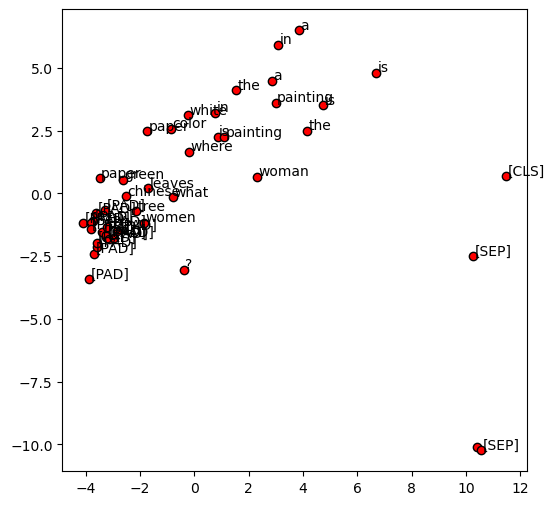

In [94]:
def display_scatterplot(data, words):

    if data.shape[1] == 2:
        twodim = data
    else:
        pca = PCA()
        pca.fit(output_embeddings.detach().numpy())
        twodim = pca.transform(data)[:,:2]
    
    plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    return

display_scatterplot(output_embeddings.detach().numpy(), input_tokens_list)

## Extract contextual word embeddings



In [96]:
import re

def get_word_idx(sent: str, word: str):
    tmp_lst = re.split(r' |\?|\.',sentence_a)
    return tmp_lst.index(word)

def get_word_vector(inputs, outputs, idx, layer):
    """Get a word vector by averaging the embeddings of 
       all word occurrences of that word in the input"""

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == idx)
    print(inputs.word_ids())
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]
    print(token_ids_word)
    return word_tokens_output.mean(dim=0)

# The code below converts the tokens into a space delimited string.
# This will allow computing in which position of the BERT input sequence a given word is.
sentence_a = tokenizer.decode(inputs["input_ids"][0].tolist()).replace("[CLS] ", '').replace(" [SEP]", '')
word = "women"
idx = get_word_idx(sentence_a, word)
print(idx)
print("Input sequence:", sentence_a)
print("The word \"", word, "\" occurs in position", idx, "of the BERT input sequence.")

word_embedding = get_word_vector(inputs, outputs, idx, 4)


7
Input sequence: what color is the paper where the women is painting? woman is painting in a white paper green leaves in a chinese tree. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
The word " women " occurs in position 7 of the BERT input sequence.
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
(array([ 8, 20]),)


In [98]:
import torch
import re
from transformers import AutoTokenizer, AutoModel

def get_word_vector_from_ab(inputs, outputs, word, layer = '-1', ab = 'A'):
    """
    This method extracts a word embedding from the requested layer 
    for sentence_a or sentence_b. If the word is divided into tokens, 
    the word embedding will be the average of the corresponding token 
    embeddings.

    NOTE: If the same word occurs multiple times in the sentence, 
    this method returns the word embedding of the first occurrence.

    Keyword arguments:
        inputs -- input passed to the transformer
        outputs -- output of the transformer
        word -- target word
        layer -- layer from where the word embedding vector should 
        be extracted.
        ab -- should be 'A' or 'B' indication if the word embedding is to be extracted 
        from sentence_a or sentence_b, i.e., query or document.
    """
       
    sep_token = np.where(np.array(inputs["input_ids"][0].tolist()) == 102)[0][0]
    if ab == 'A':
        tokens_a = inputs["input_ids"][0][1:sep_token]
        sent = tokenizer.decode(tokens_a.tolist())
    else:
        tokens_b = inputs["input_ids"][0][sep_token+1:-1]
        sent = tokenizer.decode(tokens_b.tolist())

    print(sent)
    word_ids = get_word_idx(sent, word)

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == word_ids)[0]
    sep_word = np.where(np.array(inputs.word_ids()) == None)[0][1]

    if ab == 'A':
        token_pos = token_ids_word < sep_word
    else:
        token_pos = token_ids_word > sep_word
        
    token_ids_word = token_ids_word[token_pos]
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]

    # Change this to True for inspection
    details = True
    if details:
        input_id_list = input_ids[0].tolist() # Batch index 0
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        str1 = " "

        print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
        print("INPUT SEQUENCE TOKENS: ", str1.join(tokens))
        print("TARGET WORD:", word)
        print("TARGET SENTENCE:", ab)
        print("TARGET SENTENCE WORDS [", sent, "]")
        print("The word [", word, "] occurs in position", idx, "of the BERT input sentence", ab)
        print("The word [", word, "] corresponds to the token(s)", token_ids_word, "of the BERT input sequence", ab)

    return word_tokens_output.mean(dim=0)


word_embedding = get_word_vector_from_ab(inputs, outputs, "women", 4, 'A')


what color is the paper where the women is painting?
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
INPUT SEQUENCE TOKENS:  [CLS] what color is the paper where the women is painting ? [SEP] woman is painting in a white paper green leaves in a chinese tree . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
TARGET WORD: women
TARGET SENTENCE: A
TARGET SENTENCE WORDS [ what color is the paper where the women is painting? ]
The word [ women ] occurs in position 7 of the BERT input sentence A
The word [ women ] corresponds to the token(s) [8] of the BERT input sequence A


In [99]:
word_embedding.size()

torch.Size([768])

## Self-attention matrices

In [100]:
attention = outputs['attentions']

# The format of the attention tensor is:
#     attention[layer][sample_n][head][token1][token2]

layer = 3      # Transformer layer
sample_n = 1   # Input sample
head = 3       # Head of the selected layer

In [101]:
# the score of the attention of one token vs the other token
attention[layer][sample_n][head][token_throat][token_cancer]

tensor(0.0687)

In [102]:
attention[layer][sample_n][head].size()

torch.Size([45, 45])

In [103]:
# There's a softmax, so, the sum should be 1 
attention[layer][sample_n][head][token_throat].sum()

tensor(1.)

In [104]:
attention[layer][sample_n][head][token_cancer].sum()

tensor(1.0000)

# Attention and Embeddings Visualization


In [13]:
import torch

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import logging
logging.set_verbosity_warning()

import numpy as np
import pprint

from bertviz import model_view, head_view

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))
    
def display_scatterplot(model, words):

    if model.shape[1] == 2:
        twodim = model
    else:
        twodim = PCA().fit_transform(model)[:,:2]
    
    plt.style.use('ggplot')
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)


# Model Explainability with BERT

https://github.com/PAIR-code/lit

https://github.com/jalammar/ecco

There are many models available at HuggingFace models repository. These are stable models that were made available by researchers and the industry.

https://huggingface.co/models

The example below is the most popular Transformer model, BERT, a cross-encoder trained on the Next Sentence Prediction task and Masked Language Model task:

In [15]:
model_path = 'deepset/roberta-base-squad2'

In [16]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

sentence_a = "What happens after the women finish talking with the boy?"
sentence_b = caption_text[4]
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

# If the token starts with "Ġ", remove the "Ġ"
tokens = [token[1:] if token.startswith("Ġ") else token for token in tokens]

"""repeated_word = "hello"
text = " ".join([repeated_word] * 20)
inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, max_length = 512, padding=True, truncation = True)
input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
tokens = [token[1:] if token.startswith("Ġ") else token for token in tokens]"""


print(tokens)


['<s>', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', 'hello', '</s>']


In [37]:
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions
hidden_states = outputs.hidden_states

## Visualization of embeddings

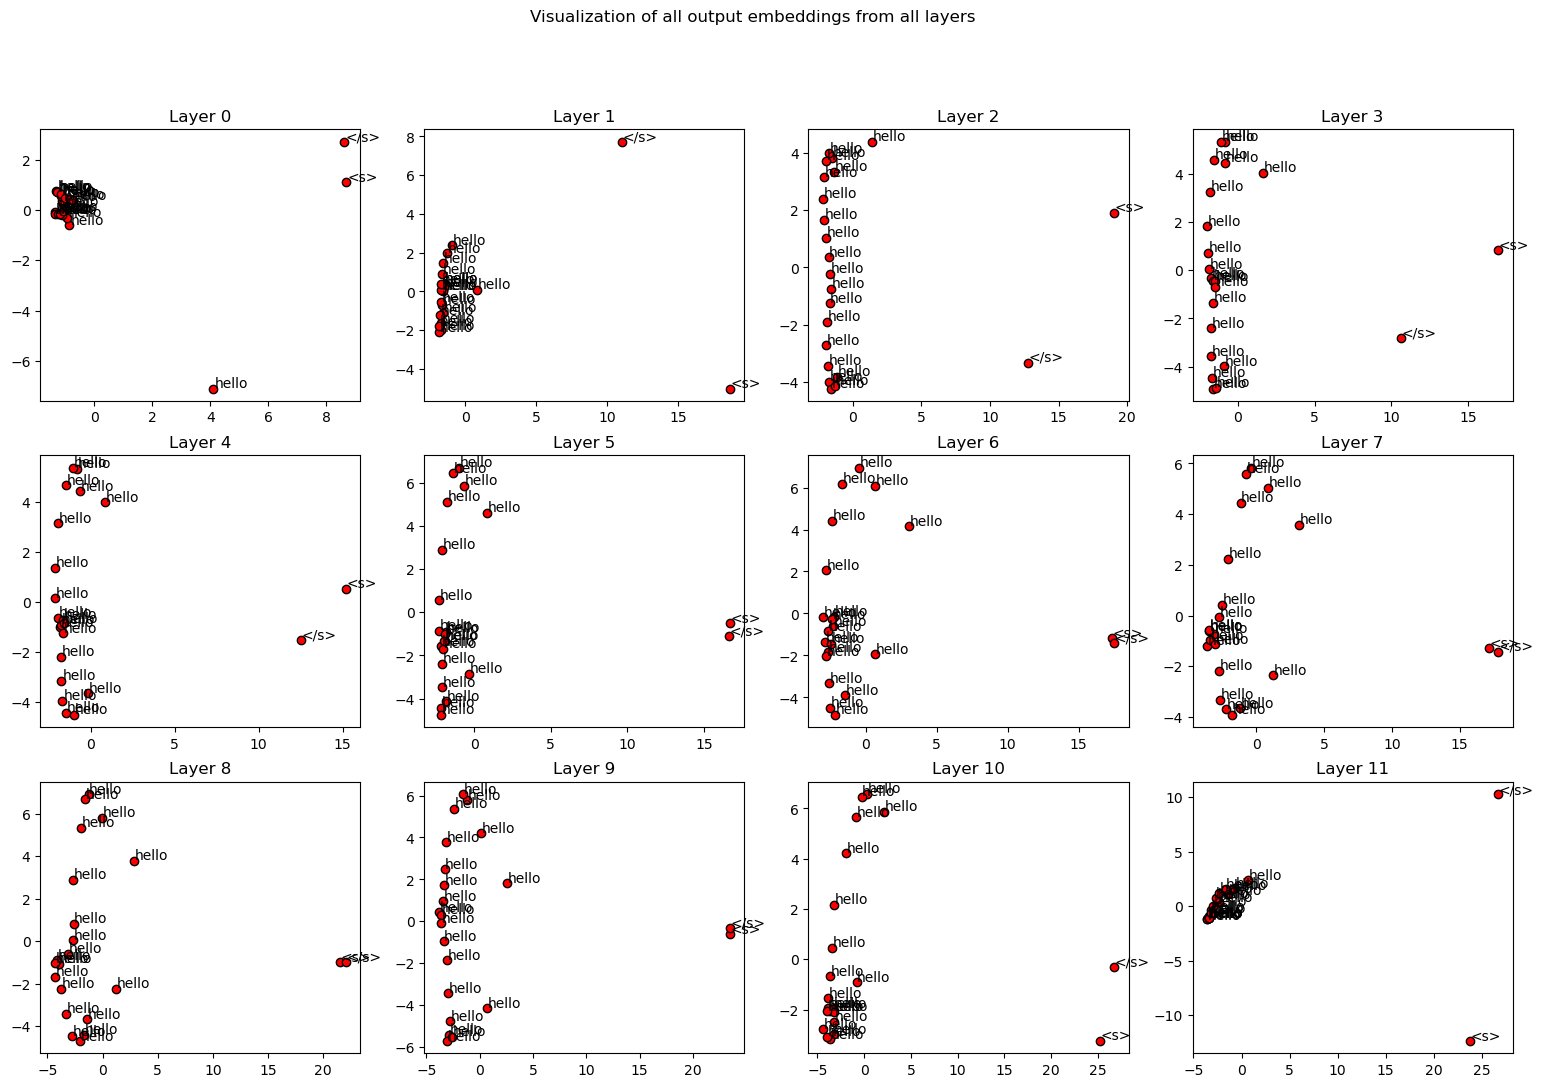

In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]

        plt.style.use('default') # https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html
        im = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
        for word, (x,y) in zip(tokens, twodim):
            ax.text(x+0.05, y+0.05, word[0:])
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

## 1. Contextual embeddings.

### Question : What color is the paper where the women is painting?
### Answer : woman is painting in a white paper green leaves in a chinese tree.

![title](Plots/embbedings_0.png)

### Question : What final touches did the woman add to complete her painting?
### Answer : woman used some black painting for make details, put the red stamp on the corner and finished the painting with yellow and reddetails on the flowers.

![title](Plots/embbedings_1.png)

### What can be seen in the sky despite the cloudy weather?
### A view of the sun is seen between the clouds.

![title](Plots/embbedings_2.png)

### What did the group of women do as the boy observed them?
### Then the group of gathered women talk as the boy watches and listens.

![title](Plots/embbedings_3.png)

### What happens after the women finish talking with the boy?
### They are then shown outside, washing their hands and doctoring the boy as they show how not to be dirty.

![title](Plots/embbedings_4.png)

## 2. Positional Embeddings.

![title](Plots/embbedings_same_word.png)

## 3. Self-Attention.

### Cross-Encoder


In [ ]:
questions = [
    "What color is the paper where the woman is painting?",
    "What final touches did the woman add to complete her painting?",
    "What can be seen in the sky despite the cloudy weather?",
    "What did the group of women do as the boy observed them?",
    "What happens after the women finish talking with the boy?"
]

call_html()

for i in range(5):
    inputs = tokenizer.encode_plus(
        questions[i],
        caption_text[i],
        return_tensors='pt',
        add_special_tokens=True,
        max_length=512,
        padding=True,
        truncation=True
    )
    input_ids = inputs['input_ids']
    input_id_list = input_ids[0].tolist()
    token_list = tokenizer.convert_ids_to_tokens(input_id_list)
    token_list = [token[1:] if token.startswith("Ġ") else token for token in token_list]

    with torch.no_grad():
        outputs = model(**inputs)
    
    attention = outputs.attentions
    head_view(attention, token_list)

### Dual encoder

In [49]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/msmarco-distilbert-base-v2", output_attentions=True)

questions_emb = encode(questions)
captions_emb = encode(caption_text)

similarities = cosine_similarity(questions_emb, captions_emb)

# Print results
print("🔍 Cosine Similarity Matrix (Dual Encoder):")
for i in range(len(questions)):
    sim_score = similarities[i][i]
    print(f"{sim_score:.4f}")

"""sentence = "What happens after the women finish talking with the boy?"

# Tokenize and forward pass
inputs = tokenizer(sentence, return_tensors='pt', truncation=True)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
with torch.no_grad():
    outputs = model(**inputs)

attention = outputs.attentions  # shape: [num_layers, batch, num_heads, seq_len, seq_len]

# Call HTML setup (for notebook display)
call_html()
head_view(attention, tokens)"""

🔍 Cosine Similarity Matrix (Dual Encoder):
0.6931
0.4697
0.5592
0.6235
0.3616


'sentence = "What happens after the women finish talking with the boy?"\n\n# Tokenize and forward pass\ninputs = tokenizer(sentence, return_tensors=\'pt\', truncation=True)\ntokens = tokenizer.convert_ids_to_tokens(inputs[\'input_ids\'][0])\nwith torch.no_grad():\n    outputs = model(**inputs)\n\nattention = outputs.attentions  # shape: [num_layers, batch, num_heads, seq_len, seq_len]\n\n# Call HTML setup (for notebook display)\ncall_html()\nhead_view(attention, tokens)'